# EMFX - Times Series Forecasting using ARIMA Model

## Import Libraries

In [1]:
# Supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import plotly.express as px
import plotly.io as pio

In [3]:
# Data manipulation
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm

In [4]:
# ADF library to check stationarity of a time series
from statsmodels.tsa.stattools import adfuller

In [5]:
# ARIMA model library
from statsmodels.tsa.arima.model import ARIMA

In [6]:
# Trading strategy analysis
import pyfolio as pf

In [7]:
# yfinance library for historical fx data
import yfinance as yf

## EMFX Historical Charts (2y lookback)

In [8]:
# CEEMEA FX historical fx data
eur_huf = yf.download('EURHUF=X', period='2y', interval='1h')[['Open', 'High', 'Low', 'Close', 'Volume']]
eur_czk = yf.download('EURCZK=X', period='2y', interval='1h')[['Open', 'High', 'Low', 'Close', 'Volume']]
eur_pln = yf.download('EURPLN=X', period='2y', interval='1h')[['Open', 'High', 'Low', 'Close', 'Volume']]
usd_zar = yf.download('USDZAR=X', period='2y', interval='1h')[['Open', 'High', 'Low', 'Close', 'Volume']]
usd_ils = yf.download('USDILS=X', period='2y', interval='1h')[['Open', 'High', 'Low', 'Close', 'Volume']]
usd_try = yf.download('USDTRY=X', period='2y', interval='1h')[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
def adj_freq(raw_df):
    # dict used for aggregation
    ohlcv_dict = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}
        
    # Resampling data to 4H frequency
    adj_df = raw_df.resample('4H', label='right', closed='right').agg(ohlcv_dict).dropna()
    
    return adj_df

In [10]:
# Apply 4H resampling function to CEEMEA FX dataframes
eur_huf = adj_freq(eur_huf)
eur_czk = adj_freq(eur_czk)
eur_pln = adj_freq(eur_pln)
usd_zar = adj_freq(usd_zar)
usd_ils = adj_freq(usd_ils)
usd_try = adj_freq(usd_try)

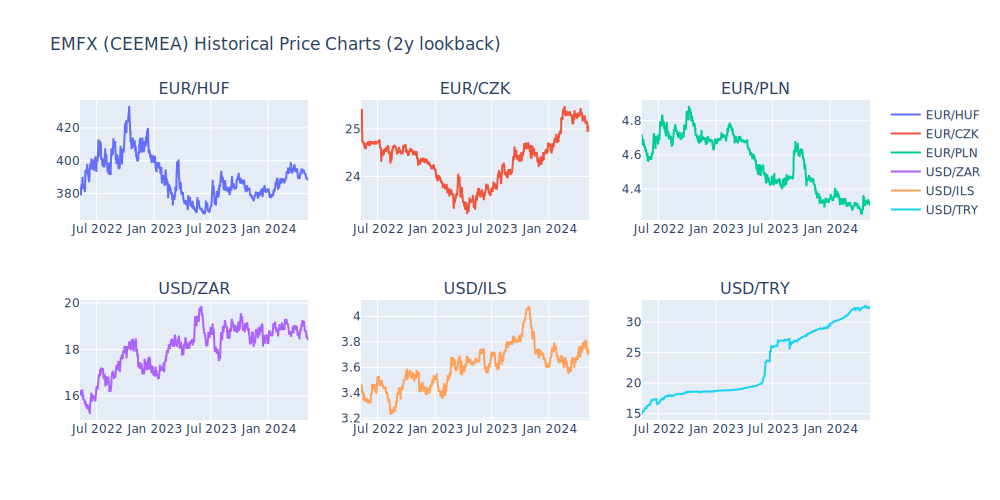

In [11]:
fig = make_subplots(rows=2, cols=3, subplot_titles=("EUR/HUF", "EUR/CZK", "EUR/PLN", "USD/ZAR", "USD/ILS", "USD/TRY"), start_cell="top-left")

fig.add_trace(go.Scatter(name='EUR/HUF', x=eur_huf.index, y=eur_huf['Close']), row=1, col=1)
fig.add_trace(go.Scatter(name='EUR/CZK', x=eur_czk.index, y=eur_czk['Close']), row=1, col=2)
fig.add_trace(go.Scatter(name='EUR/PLN', x=eur_pln.index, y=eur_pln['Close']), row=1, col=3)
fig.add_trace(go.Scatter(name='USD/ZAR', x=usd_zar.index, y=usd_zar['Close']), row=2, col=1) 
fig.add_trace(go.Scatter(name='USD/ILS', x=usd_ils.index, y=usd_ils['Close']), row=2, col=2) 
fig.add_trace(go.Scatter(name='USD/TRY', x=usd_try.index, y=usd_try['Close']), row=2, col=3) 

fig.update_layout(height=500, width=1000, title_text='EMFX (CEEMEA) Historical Price Charts (2y lookback)')
                
fig.show(renderer="svg")

In [12]:
# function to make sure there are 6 datapoints for each day (4H intervals) 
def consistency_check(raw_df):
    # Identify no of datapoints for each day
    curr_df = raw_df.groupby(raw_df.index.date).count()
    
    # Filter out dataframes which do not have 6 datapoints
    curr_df = curr_df[curr_df['Close']!=6]

    to_delete = list(pd.to_datetime(curr_df.index))
    return raw_df[~(raw_df.index.isin(to_delete))]

In [13]:
eur_huf = consistency_check(eur_huf)
eur_czk = consistency_check(eur_czk)
eur_pln = consistency_check(eur_pln)
usd_zar = consistency_check(usd_zar)
usd_ils = consistency_check(usd_ils)
usd_try = consistency_check(usd_try)

## Selection of Appropriate Time Series Model

The next step after cleaning the data is checking for **stationarity**.

- If **stationary**, then we would apply the **ARMA model** of the appropriate order.
- If it is **not stationary**, then we can take **first difference** and if the data then **becomes stationary** we will use the **ARIMA model**.

In [14]:
def stationarity_check(raw_df):
    outcome = adfuller(raw_df)
    
    if(outcome[1] < 0.05):
        return True
    else:
        return False

## Stationarity Check on EMFX Data

- **False** means the data is not stationary, so we cannot use the ARMA model and would subsequently have to check if we can apply the ARIMA model.
- **True** means the data is stationary, so we can apply the ARIMA model.

In [15]:
print("EUR/HUF: ", stationarity_check(eur_huf['Close']))
print("EUR/CZK: ", stationarity_check(eur_czk['Close']))
print("EUR/PLN: ", stationarity_check(eur_pln['Close']))
print("USD/ZAR: ", stationarity_check(usd_zar['Close']))
print("USD/ILS: ", stationarity_check(usd_ils['Close']))
print("USD/TRY: ", stationarity_check(usd_try['Close']))

EUR/HUF:  False
EUR/CZK:  False
EUR/PLN:  False
USD/ZAR:  False
USD/ILS:  False
USD/TRY:  False


Let's **take first differences** and see if this makes a difference.

In [16]:
print("EUR/HUF: ", stationarity_check(eur_huf['Close'].diff().dropna()))
print("EUR/CZK: ", stationarity_check(eur_czk['Close'].diff().dropna()))
print("EUR/PLN: ", stationarity_check(eur_pln['Close'].diff().dropna()))
print("USD/ZAR: ", stationarity_check(usd_zar['Close'].diff().dropna()))
print("USD/ILS: ", stationarity_check(usd_ils['Close'].diff().dropna()))
print("USD/TRY: ", stationarity_check(usd_try['Close'].diff().dropna()))

EUR/HUF:  True
EUR/CZK:  True
EUR/PLN:  True
USD/ZAR:  True
USD/ILS:  True
USD/TRY:  True


The data becomes stationary after taking first differences, hence we can use the **ARIMA** model.

## Finding the p, q and d order of the ARIMA model

In [17]:
def get_optimal_params(raw_df):
    
    # Split dataframe into training and test datasets
    index_no = int(len(raw_df) * 0.7)
    training_data = raw_df[:index_no]
    test_data = raw_df[index_no:]
    
    # Set range of params to test
    p = q = range(0, 5)
    d = range(1, 2)
    
    # Produce all different combinations of p, d and q 
    pdq = list(itertools.product(p, d, q))
    best_aic = float("inf")
    best_param = None
    
    for curr_params in tqdm(pdq):
        try:
            model = ARIMA(training_data.Close.values, order=curr_params)
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                optimal_params = curr_params
                best_aic = model_fit.aic
        except:
            continue
    return optimal_params, training_data, test_data

In [18]:
warnings.filterwarnings("ignore")

eur_huf_optimal_params, eur_huf_training_data, eur_huf_test_data  = get_optimal_params(eur_huf)
print("The optimal parameters for the ARIMA model based off the EUR/HUF dataset is ", eur_huf_optimal_params)

eur_czk_optimal_params, eur_czk_training_data, eur_czk_test_data  = get_optimal_params(eur_czk)
print("The optimal parameters for the ARIMA model based off the EUR/CZK dataset is ", eur_czk_optimal_params)

eur_pln_optimal_params, eur_pln_training_data, eur_pln_test_data  = get_optimal_params(eur_pln)
print("The optimal parameters for the ARIMA model based off the EUR/PLN dataset is ", eur_pln_optimal_params)

usd_zar_optimal_params, usd_zar_training_data, usd_zar_test_data  = get_optimal_params(usd_zar)
print("The optimal parameters for the ARIMA model based off the USD/ZAR dataset is ", usd_zar_optimal_params)

usd_ils_optimal_params, usd_ils_training_data, usd_ils_test_data  = get_optimal_params(usd_ils)
print("The optimal parameters for the ARIMA model based off the USD/ILS dataset is ", usd_ils_optimal_params)

usd_try_optimal_params, usd_try_training_data, usd_try_test_data  = get_optimal_params(usd_try)
print("The optimal parameters for the ARIMA model based off the USD/TRY dataset is ", usd_try_optimal_params)

100%|███████████████████████████████████████████| 25/25 [00:15<00:00,  1.59it/s]


The optimal parameters for the ARIMA model based off the EUR/HUF dataset is  (4, 1, 2)


100%|███████████████████████████████████████████| 25/25 [00:16<00:00,  1.52it/s]


The optimal parameters for the ARIMA model based off the EUR/CZK dataset is  (0, 1, 1)


100%|███████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


The optimal parameters for the ARIMA model based off the EUR/PLN dataset is  (3, 1, 2)


100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.22it/s]


The optimal parameters for the ARIMA model based off the USD/ZAR dataset is  (0, 1, 0)


100%|███████████████████████████████████████████| 25/25 [00:16<00:00,  1.50it/s]


The optimal parameters for the ARIMA model based off the USD/ILS dataset is  (3, 1, 3)


100%|███████████████████████████████████████████| 25/25 [00:21<00:00,  1.16it/s]

The optimal parameters for the ARIMA model based off the USD/TRY dataset is  (4, 1, 2)


## Forecast FX rate using optimal ARIMA model parameters

In [19]:
def predict_fx_rate(close, optimal_param):
    
    # Define model with optimal params
    optimal_model = ARIMA(close.values, order=optimal_param)
    optimal_model_fit = optimal_model.fit(method_kwargs={"warn_convergence": False})
    
    # Generate forecast
    fx_rate_predictions = optimal_model_fit.forecast(steps=1)[0]
    return fx_rate_predictions

In [20]:
# Starting point for predictions on index 
window = 2000

In [21]:
def generate_predictions(raw_train_df, optimal_params):
    raw_train_df['predicted_fx_rate'] = np.nan
    
    for i in tqdm(range(window, raw_train_df.shape[0])):
        raw_train_df['predicted_fx_rate'].iloc[i] = predict_fx_rate(raw_train_df.iloc[i-window:i].Close, optimal_params)
        
    raw_train_df = raw_train_df.iloc[window:]
    
    return raw_train_df

In [22]:
eur_huf_training_data = generate_predictions(eur_huf_training_data, eur_huf_optimal_params)
eur_czk_training_data = generate_predictions(eur_czk_training_data, eur_czk_optimal_params)
eur_pln_training_data = generate_predictions(eur_pln_training_data, eur_pln_optimal_params)
usd_zar_training_data = generate_predictions(usd_zar_training_data, usd_zar_optimal_params)
usd_ils_training_data = generate_predictions(usd_ils_training_data, usd_ils_optimal_params)
usd_try_training_data = generate_predictions(usd_try_training_data, usd_try_optimal_params)

100%|█████████████████████████████████████████| 233/233 [05:00<00:00,  1.29s/it]


In [23]:
# Rename columns for plotting purposes
eur_huf_training_data.rename(columns={'Close': 'Actual FX Rate', 'predicted_fx_rate': 'Predicted FX Rate'}, inplace=True)
eur_czk_training_data.rename(columns={'Close': 'Actual FX Rate', 'predicted_fx_rate': 'Predicted FX Rate'}, inplace=True)
eur_pln_training_data.rename(columns={'Close': 'Actual FX Rate', 'predicted_fx_rate': 'Predicted FX Rate'}, inplace=True)
usd_zar_training_data.rename(columns={'Close': 'Actual FX Rate', 'predicted_fx_rate': 'Predicted FX Rate'}, inplace=True)
usd_ils_training_data.rename(columns={'Close': 'Actual FX Rate', 'predicted_fx_rate': 'Predicted FX Rate'}, inplace=True)
usd_try_training_data.rename(columns={'Close': 'Actual FX Rate', 'predicted_fx_rate': 'Predicted FX Rate'}, inplace=True)

## CEEMEA FX - Predicted vs Actual (charts)

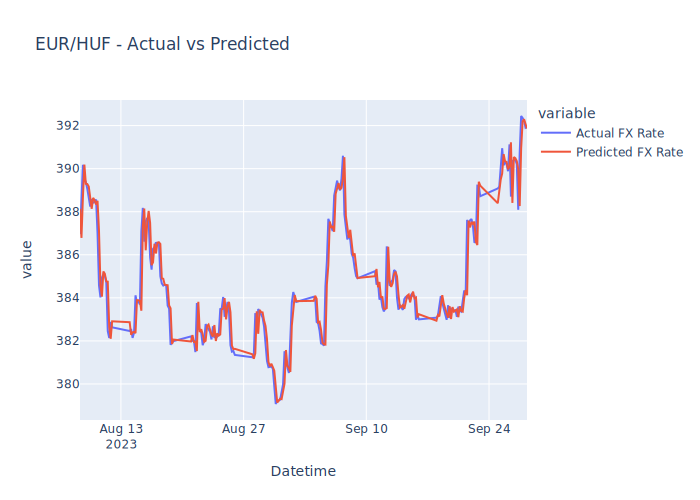

In [24]:
fig = px.line(eur_huf_training_data, x=eur_huf_training_data.index, y=['Actual FX Rate', 'Predicted FX Rate'], title='EUR/HUF - Actual vs Predicted')
fig.show(renderer="svg")

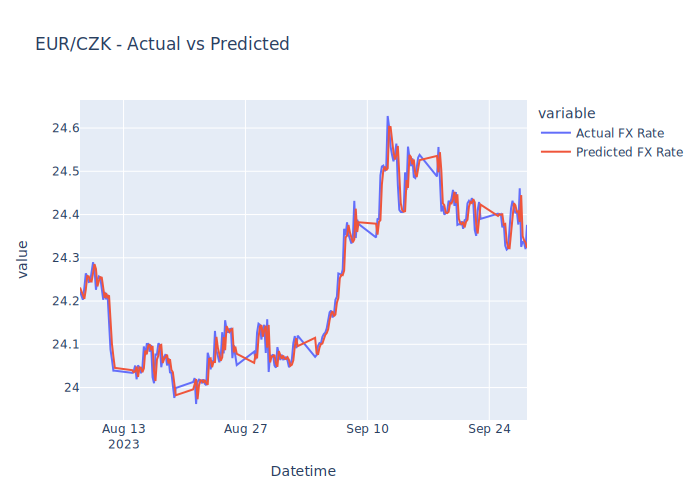

In [25]:
fig = px.line(eur_czk_training_data, x=eur_czk_training_data.index, y=['Actual FX Rate', 'Predicted FX Rate'], title='EUR/CZK - Actual vs Predicted')
fig.show(renderer="svg")

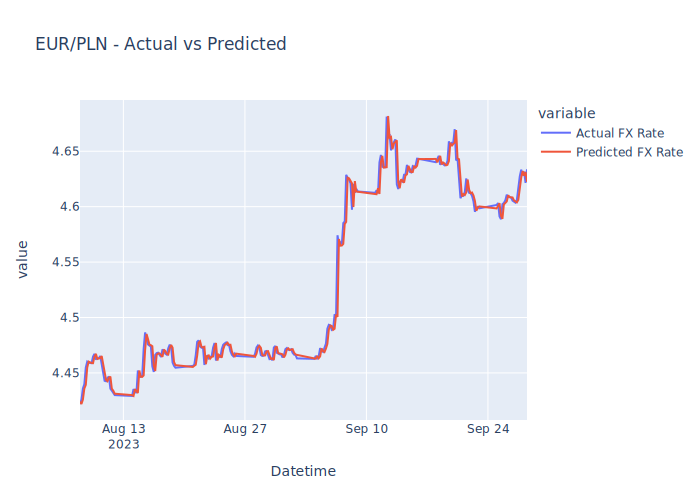

In [26]:
fig = px.line(eur_pln_training_data, x=eur_pln_training_data.index, y=['Actual FX Rate', 'Predicted FX Rate'], title='EUR/PLN - Actual vs Predicted')
fig.show(renderer="svg")

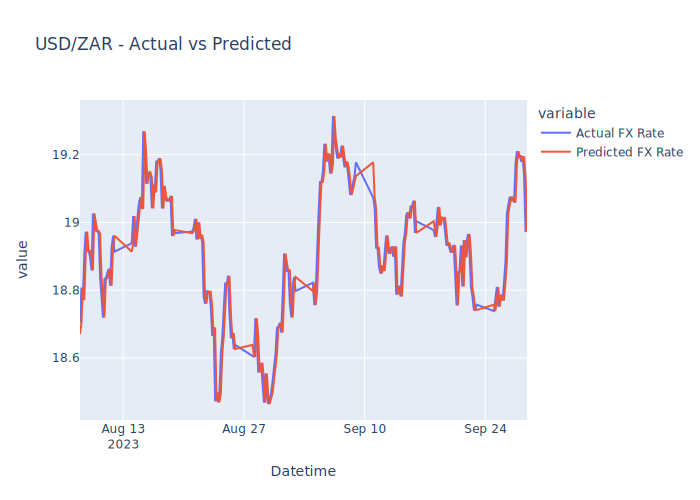

In [27]:
fig = px.line(usd_zar_training_data, x=usd_zar_training_data.index, y=['Actual FX Rate', 'Predicted FX Rate'], title='USD/ZAR - Actual vs Predicted')
fig.show(renderer="svg")

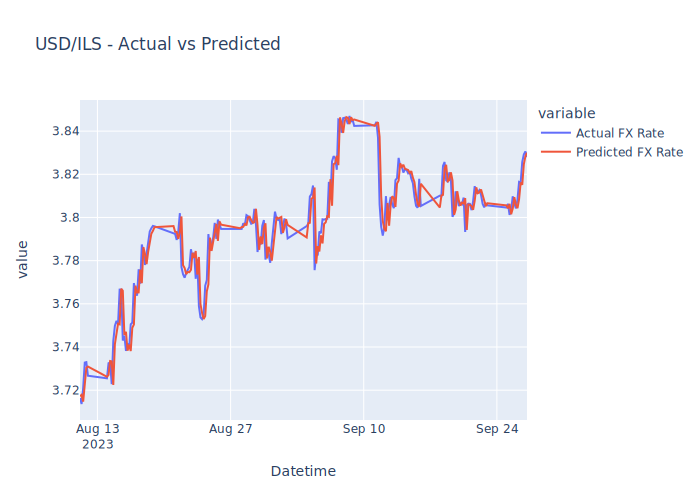

In [28]:
fig = px.line(usd_ils_training_data, x=usd_ils_training_data.index, y=['Actual FX Rate', 'Predicted FX Rate'], title='USD/ILS - Actual vs Predicted')
fig.show(renderer="svg")

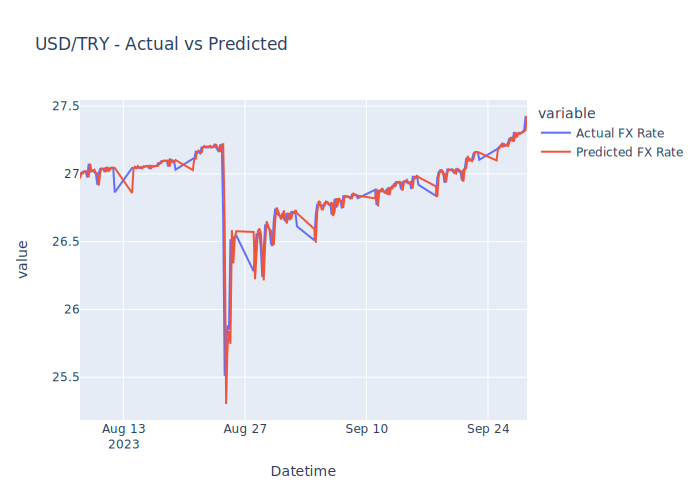

In [29]:
fig = px.line(usd_try_training_data, x=usd_try_training_data.index, y=['Actual FX Rate', 'Predicted FX Rate'], title='USD/TRY - Actual vs Predicted')
fig.show(renderer="svg")